# Reto 1

## Ingeniería de características

#### Miguel Ortiz y Andrea Castiella

In [14]:
import numpy  as np
import pandas as pd
import OurUtils as our
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

In [15]:
FullSet_3 = pd.read_csv('../Reto1-Dataset/1000_tres.csv', header=None)
FullSet_7 = pd.read_csv('../Reto1-Dataset/1000_siete.csv', header=None)

# Reescalado a [0, 1]

FullSet_3 = FullSet_3 / 255.0
FullSet_7 = FullSet_7 / 255.0

## Función extracción de características

In [16]:
def feat_extraction(data, perc=0.3, perc2=0.45, alfa=0.5, adjust=True):
    num_feat = 9
    features = np.zeros([data.shape[0], num_feat])
    data = data.values.reshape([data.shape[0],28,28]) # Cada fila es una imagen, reshape a 28x28

    for i in range(data.shape[0]): # Por cada imagen
        img = data[i,:,:]
        if adjust:
            img = our.ajuste_numero(img) # Devuelve una imagen con el número ajustado
        # Característica 1
        img_left = img[:, :int(img.shape[1]*(perc))]
        # feat_1  = np.sum(img_izq) # Suma de los pixels del % izquierdo de la imagen
        feat_1 = np.sum(img_left > 0.5)/(img_left.shape[0]*img_left.shape[1]) # Porcentaje de pixels del % izquierdo de la imagen > 128 (0.5)
        features[i, 0] = feat_1
        # Característica 2
        img_inf = img[int(img.shape[0]*(1-perc)):, :]
        # feat_2 = np.sum(img_inf) # Suma de los pixels del % inferior de la imagen
        feat_2 = np.sum(img_inf > 0.5)/(img_inf.shape[0]*img_inf.shape[1]) # Porcentaje de pixels del % inferior de la imagen > 128 (0.5)
        features[i, 1] = feat_2
        # Característica 3
        img_right = img[:, int(img.shape[1]*(1-perc)):]
        # feat_3 = np.sum(img_der) # Suma de los pixels del % derecho de la imagen
        feat_3 = np.sum(img_right > 0.5)/(img_right.shape[0]*img_right.shape[1]) # Porcentaje de pixels del % derecha de la imagen > 128 (0.5)
        features[i, 2] = feat_3
        # Característica 4
        img_sup = img[:int(img.shape[0]*(perc)), :]
        # feat_4 = np.sum(img_sup) # Suma de los pixels del % superior de la imagen
        feat_4 = np.sum(img_sup > 0.5)/(img_sup.shape[0]*img_sup.shape[1]) # Porcentaje de pixels del % superior de la imagen > 128 (0.5)
        features[i, 3] = feat_4
        # Característica 5
        img_cuad = img[int(img.shape[0]*(1-perc)):,int(img.shape[1]*(perc)):]
        # feat_5 = np.sum(img_cuad) # Suma del cuadrante inferior derecho
        feat_5 = np.sum(img_cuad > 0.5)/(img_cuad.shape[0]*img_cuad.shape[1]) # Porcentaje de pixels del % superior de la imagen > 128 (0.5)
        features[i, 4] = feat_5
        # Característica 6
        feat_6 = np.amax(np.sum(img, axis=0)) # Máximo valor de la suma de las columnas
        features[i, 5] = feat_6
        # Característica 7
        img_inf = img[int(img.shape[0]*(1-perc)):, :] # % inferior
        sum_cols = img_inf.sum(axis=0)
        indc = np.argwhere(sum_cols > alfa * sum_cols.max())
        feat_7 = indc[-1] - indc[0] # Ancho dependiente de theta del % inferior de la imagen.
        features[i, 6] = feat_7
        # Característica 8
        img_inf = img[int(img.shape[0]*(1-perc)):, :] # % inferior
        sum_rows = img_inf.sum(axis=1)
        indr = np.argwhere(sum_rows > alfa * sum_rows.max())
        feat_8 = indr[-1] - indr[0] # Alto dependiente de theta del % inferior de la imagen.
        features[i, 7] = feat_8
        # Caracteristica 9
        img_upper = img[:int(img.shape[0]*(perc2)), :]
        sum_rows = img_upper.sum(axis=1)
        idx_row = sum_rows.argmax()
        img_row = img_upper[idx_row, :]
        args = np.argwhere( img_row > 0.6)
        distance_upper = args[-1,0] - args[0,0]
        if distance_upper == 0:
            distance_upper = 0.01
        img_lower = img[int(img.shape[0]*(1-perc2)):, :]
        sum_rows = img_lower.sum(axis=1)
        idx_row = sum_rows.argmax()
        img_row = img_lower[idx_row, :]
        args = np.argwhere( img_row > 0.6)
        distance_lower = args[-1,0] - args[0,0]
        features[i, 8] = float(distance_lower)/float(distance_upper) # Max upper distance / max lower distance
    col_names = ['feat_1','feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9']
    return pd.DataFrame(features,columns = col_names)

## Ingeniería de características

In [17]:
# Multiplica el valor de dos características dadas
def feat_mult(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-5'):
    mult = features[feat1] * features[feat2]
    return pd.DataFrame({feat_name:mult})

# Divide el valor de dos características dadas
def feat_div(features, feat_name='', feat1 = 'feat_2', feat2 = 'feat-4'):
    div = features[feat1] / (features[feat2] + 0.00001)
    return pd.DataFrame({feat_name:div})

## Features

In [18]:
FullSet = our.join_features_labels(FullSet_3, FullSet_7)
seed = 1234
theta = 0.5
X_full = feat_extraction( FullSet.drop('label', axis=1))
area = feat_mult(X_full, 'area', feat1='feat_7', feat2='feat_8')
X_full = pd.concat([X_full, area],axis=1)
mult_25 = feat_mult(X_full, 'mult_25', feat1='feat_2', feat2='feat_5')
X_full = pd.concat([X_full, mult_25],axis=1)
div_24 = feat_div(X_full, 'div_24', feat1='feat_2', feat2='feat_4')
X_full = pd.concat([X_full, div_24],axis=1)
#X_full.head()
Y_full = FullSet[['label']]
test_size = 0.2
splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
split_ix = splitter.split(X_full,Y_full)

for train_ix, test_ix in split_ix:
    X_train = X_full.loc[train_ix].reset_index(drop=True)
    #Reordena los índices
        #print(X_full.loc[train_ix])
        #print(X_train)
    Y_train = Y_full.loc[train_ix].reset_index(drop=True)
    X_test  = X_full.loc[test_ix].reset_index(drop=True)
    Y_test  = Y_full.loc[test_ix].reset_index(drop=True)

In [19]:
feats = ['feat_9', 'div_24']
scaler = MinMaxScaler()
X = scaler.fit_transform(X_train[feats])
Y = Y_train.values.ravel() #Devuelve data como numpy

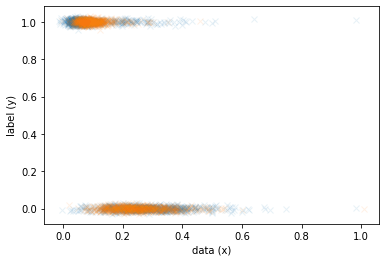

In [20]:
plt.plot(our.jitter(X,sigma=0.01), our.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Logistic Regression

[0.69958795 0.18176909 0.76461568 ... 0.13857005 0.10794604 0.18502554]


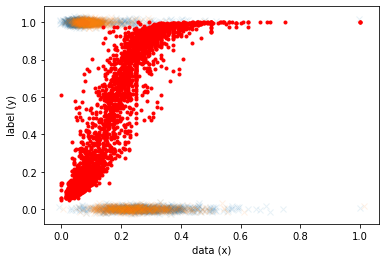

In [21]:
from sklearn.linear_model import LogisticRegression

recta_regresion = LogisticRegression()
recta_regresion.fit(X,Y)
y_CDF = recta_regresion.predict_proba(X)
y_pred = y_CDF[:,0]  #<-- use 0 instead of 1 to see the logistic curve of the other class
print(y_pred)

plt.plot(our.jitter(X,sigma=0.01), our.jitter(Y,sigma=0.01),'x',alpha=0.1)
plt.plot(X, y_pred, '.r')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
X_test = scaler.transform(X_test[feats])
y_test_pred = recta_regresion.predict(X_test)
conf_mat = confusion_matrix(Y_test, y_test_pred)
hits = conf_mat[0,0]+conf_mat[1,1]
fails = conf_mat[0,1]+conf_mat[1,0]
strlog = "Fold : HITS = %d, FAILS = %d" %(hits , fails )
print(strlog)

Fold : HITS = 376, FAILS = 24


In [ ]:
## Discriminant Function

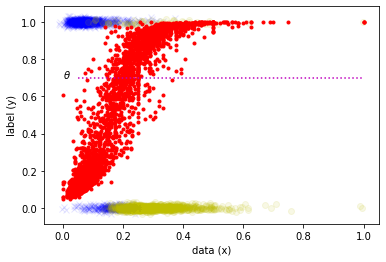

In [23]:
theta = 0.7 # Parámetro que define la función de discriminación.

ix_1 = y_pred < theta
ix_0 = ~ix_1
plt.plot( our.jitter(X[ix_1],sigma=0.01), \
          our.jitter(Y[ix_1],sigma=0.01), \
          'bx',alpha=0.1)
plt.plot( our.jitter(X[ix_0],sigma=0.01), \
          our.jitter(Y[ix_0],sigma=0.01), \
          'yo',alpha=0.1)
plt.text(0,theta, r'$ \theta $')
plt.plot(X,y_pred,'.r')
plt.plot([0.05,1],[theta,theta],'m:')
plt.xlabel('data (x)'); plt.ylabel('label (y)')
plt.show()

## Competition data

In [24]:
# Using the transform method we can use the same mean and variance as it is calculated
# from our training data to transform our test data (using fit_transform). Thus, the
# parameters learned by our model using the training data will help us to transform our test data.

# load competition data
challenge_data = pd.read_csv('../Reto1-Dataset/reto1_X.csv', header=None)
challenge_data = challenge_data/255.0
challenge_features = feat_extraction(challenge_data)
area = feat_mult(challenge_features, 'area', feat1='feat_7', feat2='feat_8')
challenge_features = pd.concat([challenge_features, area],axis=1)
mult_25 = feat_mult(challenge_features, 'mult_25', feat1='feat_2', feat2='feat_5')
challenge_features = pd.concat([challenge_features, mult_25],axis=1)
div_24 = feat_div(challenge_features, 'div_24', feat1='feat_2', feat2='feat_4')
challenge_features = pd.concat([challenge_features, div_24],axis=1)
challenge_features = scaler.transform(challenge_features[feats])
y_challenge = recta_regresion.predict_proba(challenge_features)
y_challenge_pred = y_challenge[:,1]
ix_3_chall = y_challenge_pred < theta
ix_7_chall = ~ix_3_chall
print(y_challenge)
print(ix_7_chall)


[[0.07772069 0.92227931]
 [0.1177556  0.8822444 ]
 [0.18528119 0.81471881]
 ...
 [0.96633803 0.03366197]
 [0.70834529 0.29165471]
 [0.07895944 0.92104056]]
[ True  True  True ... False False  True]


In [25]:
np.savetxt('reto1_Ypred.csv', ix_7_chall, fmt='%i', delimiter=',')

In [ ]:
# Challenge images representation
img_chall = 23
chall_results = pd.read_csv('../Reto1-Dataset/reto1_X.csv', header=None)
chall_results = chall_results / 255.0
data_chall = chall_results.values.reshape([chall_results.shape[0],28,28])
img_chall = data_chall[img_chall,:,:]
plt.imshow(img_chall)

In [ ]:
# '3' examples
num_3 = 78 # Image number
data_3 = FullSet_3.values.reshape([FullSet_3.shape[0],28,28])
img_3 = data_3[num_3,:,:]
plt.imshow(img_3)

# '7' examples
num_7 = 78 # Image number
data_7 = FullSet_3.values.reshape([FullSet_7.shape[0],28,28])
img_7 = data_7[num_7,:,:]
plt.imshow(img_7)